In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
# load ground truth Excel sheet
df = pd.read_excel('Capstone Ground Truth.xlsx')
df.head()

,Searcher,Query ID,Query,Stemmed Query,docID_Okapi,Result_Okapi,Ranking (user),Relevant?,Score_Okapi,Unnamed: 9,docID_MaxFreq,Result_MaxFreq,Ranking (user).1,Relevant?.1,Score_MaxFreq
0,Trevor,q1,Speech language pathology,"['speech', 'languag', 'patholog']",d334,https://en.wikipedia.org/wiki/Speech_recogniti...,3,False,9.383,NaN,d334,https://en.wikipedia.org/wiki/Speech_recogniti...,3,False,6.694
1,Trevor,q1,Speech language pathology,"['speech', 'languag', 'patholog']",d106,https://en.wikipedia.org/wiki/Artificial_intel...,4,False,8.062,NaN,d106,https://en.wikipedia.org/wiki/Artificial_intel...,4,False,5.050
2,Trevor,q1,Speech language pathology,"['speech', 'languag', 'patholog']",d548,https://en.wikipedia.org/wiki/Barack_Obama_spe...,5,False,6.746,NaN,d301,https://en.wikipedia.org/wiki/Health_informatics,1,True,4.870
3,Trevor,q1,Speech language pathology,"['speech', 'languag', 'patholog']",d301,https://en.wikipedia.org/wiki/Health_informatics,1,True,6.403,NaN,d303,https://en.wikipedia.org/wiki/Health_informati...,2,True,4.870
4,Trevor,q1,Speech language pathology,"['speech', 'languag', 'patholog']",d303,https://en.wikipedia.org/wiki/Health_informati...,2,True,6.403,NaN,d499,https://en.wikipedia.org/wiki/Mental_health_in...,5,False,4.836


In [3]:
# capture the relevance judges for OkapiBM25 and TF Maximum Frequency Normalization per query in two separate dictionaries 

df_okapi = df[['Query ID','Result_Okapi','Ranking (user)','Relevant?']]
reljudges_okapi = df_okapi.groupby('Query ID')['Relevant?'].apply(lambda x: x.tolist()).to_dict()

df_maxfreq = df[['Query ID','Result_MaxFreq','Ranking (user).1','Relevant?.1']]
reljudges_maxfreq = df_maxfreq.groupby('Query ID')['Relevant?.1'].apply(lambda x: x.tolist()).to_dict()

### Mean Average Precision and Precision-Recall Curve

In [4]:
def eval_metrics(reljudges):
    """
    Calculate average precision per query and mean average precision over all queries
    input: list relevance judgements with TRUE/FALSE entries per query
    output: - average precision per query 
            - mean average precision over all queries
            - dictionary containing all precision@Ns and recall@Ns per query. Dictionary is return in the form: {query_id: (list precision@Ns, list recall@Ns)}
    References: - https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
                - https://www.educative.io/answers/what-is-the-mean-average-precision-in-information-retrieval
                - https://www.cl.cam.ac.uk/teaching/1415/InfoRtrv/lecture5.pdf
    """
        
    # dict to store the average precision per query
    avg_pre = {}
    # dict to capture all precision@Ns and recall@Ns per query
    prec_rec_dict = {}
    
    for q in reljudges:
        # temporary lists to store the precision@N and recall@N for each query
        prec_list, rec_list = [], [] # <- stores only "recall points" per query, i.e. where document is relevant 
        prec_list_all, rec_list_all = [], [] # <- stores all precision and recall values per query
        
        for c in range(1,len(reljudges[q])+1):
            rel_retr = sum(reljudges[q][:c])
            retr = len(reljudges[q][:c])
            # capture only "recall points"
            if reljudges[q][c-1] == True:
                precision = rel_retr / retr
                recall = rel_retr / sum(reljudges[q]) 
                prec_list.append(precision)
                rec_list.append(recall)
            # capture all precision and recall values. Note: if-statement will be skipped when no relevant document exists per query
            if sum(reljudges[q])>0:
                precision2 = rel_retr / retr
                recall2 = rel_retr / sum(reljudges[q]) 
                prec_list_all.append(precision2)
                rec_list_all.append(recall2)
        
            # calculate average precision per query and store it in avg_pre
            if sum(reljudges[q])!=0:
                avg_pre[q] = sum(prec_list)/sum(reljudges[q])
                prec_rec_dict[q] = prec_list_all, rec_list_all
            
    # calculate mean average precision (for all queries)
    mean_avg_pre = np.mean(list(avg_pre.values()))
    
    return avg_pre, mean_avg_pre, prec_rec_dict

In [5]:
# get metrics for OkapiBM25 and TF Maximum Frequency Normalization 

avg_pre_okapi, mean_avg_pre_okapi, prec_rec_dict_okapi = eval_metrics(reljudges_okapi)

avg_pre_maxfreq, mean_avg_pre_maxfreq, prec_rec_dict_maxfreq = eval_metrics(reljudges_maxfreq)

print(f"MAP Okapi: {mean_avg_pre_okapi}") 
print(f"MAP MaxFreq: {mean_avg_pre_maxfreq}") 

MAP Okapi: 0.8041666666666667
MAP MaxFreq: 0.7797222222222223


In [6]:
def eleven_point_prec_rec(prec_rec_dict):
    ''' 
    Calculates an interpolated precision based on 11 recall points and averages them for all queries
    input: dictionary with precision and recall values per query
    output: interpolated precision values
    References: - https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html, 
                - https://www.tutorialspoint.com/how-to-draw-a-precision-recall-curve-with-interpolation-in-python-matplotlib, 
                - https://www.youtube.com/watch?v=yjCMEjoc_ZI
    '''
    # initialize list for interpolated precisions for all queries
    list_prec_int_queries = []
    # recall values 0.0, 0.1, ..., 1.0
    x11 = np.arange(0, 1.1, 0.1)

    # loop over all queries in dict prec_rec_dict
    for q, (p,r) in prec_rec_dict.items():
        # calculate inperpolated precision using formula p_interp = max(p(r')): interpolated precision p_interp at a certain recall level r is defined as the highest precision found for any recall level r' >= r 
        p_max_int = p.copy()
        i = len(r) - 2
        while i >= 0:
            if p_max_int[i + 1] > p_max_int[i]:
                p_max_int[i] = p_max_int[i + 1]
            i = i - 1
        # interpolate values for recall values x11
        x = r.copy()
        x.insert(0,0)
        y = p_max_int.copy()
        y.insert(0,1)
        f = interpolate.interp1d(x, y)
        list_prec_int_queries.append(f(x11))      

    # return mean over all queries
    return np.mean(list_prec_int_queries, axis=0)

In [7]:
# get the precision values based on 11 recall points for OkapiBM25 and TF Maximum Frequency Normalization 

elepoint_prec_okapi = eleven_point_prec_rec(prec_rec_dict_okapi)
elepoint_prec_maxfreq = eleven_point_prec_rec(prec_rec_dict_maxfreq)

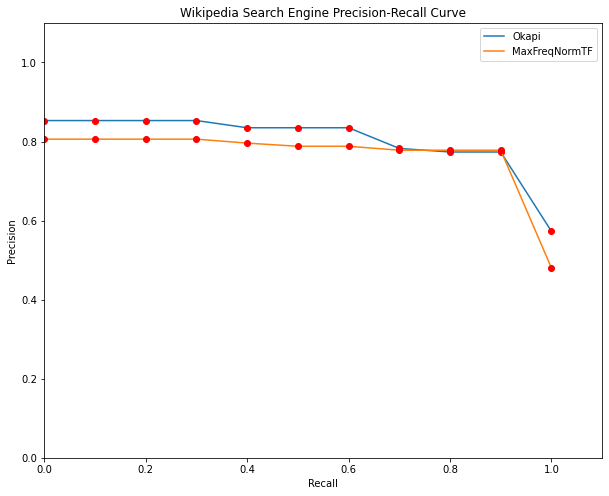

In [8]:
# plot precision recall curve for both OkapiBM25 and TF Maximum Frequency Normalization retrieval function

x11 = np.arange(0, 1.1, 0.1)
plt.figure(figsize = (10,8))
plt.plot(x11, elepoint_prec_okapi,'-', label='Okapi')
plt.plot(x11, elepoint_prec_okapi,'ro')
plt.plot(x11, elepoint_prec_maxfreq,'-', label='MaxFreqNormTF')
plt.plot(x11, elepoint_prec_maxfreq,'ro')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.title("Wikipedia Search Engine Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision");
plt.legend();